In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from src.data.datasets import ModelParamsDataset
from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

## Custom implementation

In [3]:
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(36, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 33),
        )
        
    def forward(self, x, t, angle):
        x = torch.cat([x, t, angle], dim=1)
        out = self.layers(x)
        return out
    
def linear_beta_schedule(timesteps):
    return torch.linspace(1e-4, 0.02, timesteps)

def forward_diffusion(x0, t, betas):
    alpha = 1 - betas
    alpha_bar = torch.cumprod(alpha, dim=0)
    
    # Select alpha_bar[t] for each element in the batch
    alpha_bar_t = alpha_bar[t]

    # Generate random Gaussian noise
    noise = torch.randn_like(x0)

    # Apply the forward process: x_t = sqrt(alpha_bar_t) * x0 + sqrt(1 - alpha_bar_t) * noise
    x_t = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
    return x_t, noise

def diffusion_loss(noise, noise_pred):
    return ((noise - noise_pred) ** 2).mean()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
lr = 1e-3
epochs = 1000
num_timesteps = 1000
batch_size = 64

# Model
diffusion_model = DiffusionModel()
diffusion_model.to(device)
optimizer = optim.Adam(diffusion_model.parameters(), lr=lr)

# Dataset
dataset = ModelParamsDataset("../data/eight_angles_small.csv")
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

path = "../models/generators/diffusion/"
model_path = path + "diffusion_conditional.pth"


In [ ]:
# Train loop
betas = linear_beta_schedule(num_timesteps).to(device)
losses = []

for epoch in tqdm(range(epochs)):
    for x_0, y in data_loader:
        x_0 = x_0.to(device)

        # Angle encoding
        y = y * torch.pi / 180
        sin = torch.sin(y)
        cos = torch.cos(y)
        angle = torch.cat([sin[:, None], cos[:, None]], dim=1).to(device)

        # Random timesteps
        t = torch.randint(0, num_timesteps, (batch_size, 1)).to(device)

        x_t, noise = forward_diffusion(x_0, t, betas)
        noise_pred = diffusion_model(x_t, t, angle)

        loss = diffusion_loss(noise, noise_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())


torch.save(diffusion_model.state_dict(), model_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 1.0274263620376587
Epoch 5: Loss 0.9878096580505371
Epoch 10: Loss 0.9928209781646729
Epoch 15: Loss 0.7326615452766418
Epoch 20: Loss 0.6897904276847839
Epoch 25: Loss 0.6834210157394409
Epoch 30: Loss 0.6804494261741638
Epoch 35: Loss 0.6063604354858398
Epoch 40: Loss 0.5970298647880554
Epoch 45: Loss 0.59478759765625
Epoch 50: Loss 0.514032781124115
Epoch 55: Loss 0.5285487771034241
Epoch 60: Loss 0.5180857181549072
Epoch 65: Loss 0.5424354076385498
Epoch 70: Loss 0.44863009452819824
Epoch 75: Loss 0.43661609292030334
Epoch 80: Loss 0.5535869598388672
Epoch 85: Loss 0.5250987410545349
Epoch 90: Loss 0.46243828535079956
Epoch 95: Loss 0.462398499250412
Epoch 100: Loss 0.3994157314300537
Epoch 105: Loss 0.4160328209400177
Epoch 110: Loss 0.4587927460670471
Epoch 115: Loss 0.45938169956207275
Epoch 120: Loss 0.3138546943664551
Epoch 125: Loss 0.4731296896934509
Epoch 130: Loss 0.4385688900947571
Epoch 135: Loss 0.4522135853767395
Epoch 140: Loss 0.40805208683013916
Epoch 

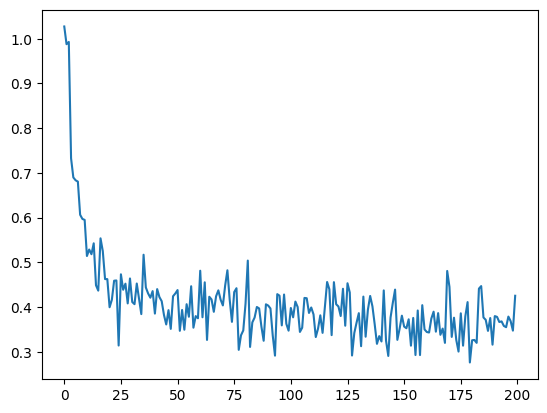

In [ ]:
plt.plot(losses)

In [ ]:
def generate(model, angle, num_timesteps):
    x_t = torch.randn(1, 33)
    angle = torch.tensor([angle * torch.pi / 180])
    sin = torch.sin(angle)
    cos = torch.cos(angle)
    angle = torch.cat([sin[None, :], cos[None, :]], dim=1)

    betas = linear_beta_schedule(num_timesteps)
    for t in reversed(range(num_timesteps)):
        t = torch.tensor([t])
        noise_pred = model(x_t, t[:, None], angle)
        beta_t = betas[t]
        alpha_t = 1 - beta_t

        x_t = (x_t - betas[t] * noise_pred) / alpha_t

        if t > 0:
            x_t += torch.sqrt(beta_t) * torch.randn_like(x_t)
    
    return x_t

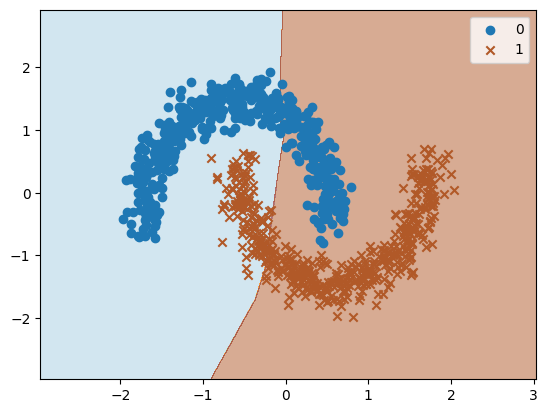

In [ ]:
diffusion_model = DiffusionModel()
diffusion_model.load_state_dict(torch.load(model_path))
diffusion_model.eval()

angle = 45
x = generate(diffusion_model, angle, 1000)[0]
X, y = get_moons_dataset()
plot_decision_boundary(x, X, y)

## Tiny diffusion

In [7]:
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [8]:

'''Different methods for positional embeddings. These are not essential for understanding DDPMs, but are relevant for the ablation study.'''

import torch
from torch import nn
from torch.nn import functional as F


class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = emb.to(x.device)
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size


class LinearEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x / self.size * self.scale
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class LearnableEmbedding(nn.Module):
    def __init__(self, size: int):
        super().__init__()
        self.size = size
        self.linear = nn.Linear(1, size)

    def forward(self, x: torch.Tensor):
        return self.linear(x.unsqueeze(-1).float() / self.size)

    def __len__(self):
        return self.size


class IdentityEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1)

    def __len__(self):
        return 1


class ZeroEmbedding(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: torch.Tensor):
        return x.unsqueeze(-1) * 0

    def __len__(self):
        return 1



In [9]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.time_mlp = SinusoidalEmbedding(128)
        # self.angle_mlp1 = SinusoidalEmbedding(128, scale=25.0)
        # self.angle_mlp2 = SinusoidalEmbedding(128, scale=25.0)

        self.joint_mlp = nn.Sequential(
            nn.Linear(163, 1024),
            nn.GELU(),
            nn.Linear(1024, 1024),
            nn.GELU(),
            nn.Linear(1024, 1024),
            nn.GELU(),
            nn.Linear(1024, 1024),
            nn.GELU(),
            nn.Linear(1024, 1024),
            nn.GELU(),
            nn.Linear(1024, 33),
        )

    def forward(self, x, t, angle):
        t_emb = self.time_mlp(t)
        # angle_emb1 = self.angle_mlp1(angle[:, 0])
        # angle_emb2 = self.angle_mlp2(angle[:, 1])
        
        # x = torch.cat((x, t_emb, angle_emb1, angle_emb2), dim=-1)
        x = torch.cat((x, t_emb, angle), dim=-1)
        x = self.joint_mlp(x)
        return x

In [10]:
def add_noise(x_0, noise, alphas_cumprod, t):
    sqrt_alphas_cumprod = alphas_cumprod ** 0.5
    sqrt_one_minus_alphas_cumprod = (1 - alphas_cumprod) ** 0.5

    s1 = sqrt_alphas_cumprod[t]
    s2 = sqrt_one_minus_alphas_cumprod[t]

    s1 = s1.reshape(-1, 1)
    s2 = s2.reshape(-1, 1)

    return s1*x_0 + s2*noise

def reconstruct_xt(noise, x_t, t, betas):
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, axis=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.)

        sqrt_inv_alphas_cumprod = torch.sqrt(1 / alphas_cumprod)
        sqrt_inv_alphas_cumprod_minus_one = torch.sqrt(1 / alphas_cumprod - 1)

        posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)
        posterior_mean_coef2 = (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod)

        s1 = sqrt_inv_alphas_cumprod[t]
        s2 = sqrt_inv_alphas_cumprod_minus_one[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        pred_x0 = s1 * x_t - s2 * noise

        posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)
        posterior_mean_coef2 = (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod)
        s1 = posterior_mean_coef1[t]
        s2 = posterior_mean_coef2[t]
        s1 = s1.reshape(-1, 1)
        s2 = s2.reshape(-1, 1)
        x_t = s1 * pred_x0 + s2 * x_t

        variance = 0
        if t > 0:
            variance = betas[t] * (1. - alphas_cumprod_prev[t]) / (1. - alphas_cumprod[t])
            variance = variance.clip(1e-20)
            noise = torch.randn_like(noise)
            variance = (variance ** 0.5) * noise

        pred_prev_sample = x_t + variance

        return pred_prev_sample

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
lr = 1e-3
epochs = 1000
num_timesteps = 1000
batch_size = 128
beta_schedule = "linear"
betas = torch.tensor(np.linspace(1e-4, 0.02, num_timesteps), dtype=torch.float32)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# Dataset
dataset = ModelParamsDataset("../data/eight_angles_small.csv")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
model = MLP()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

save_path = "../models/generators/diffusion/"
model_path = save_path + "diffusion_conditional.pth"

In [ ]:
model.train()

losses = []

for epoch in tqdm(range(epochs)):
    for (X, y) in dataloader:
        noise = torch.randn(X.shape)
        timesteps = torch.randint(0, num_timesteps, (X.shape[0],)).long()

        y = y * torch.pi / 180
        sin = torch.sin(y)
        cos = torch.cos(y)
        angle = torch.cat([sin[:, None], cos[:, None]], dim=1)

        noisy = add_noise(X, noise, alphas_cumprod, timesteps)

        timesteps = timesteps.to(device)
        angle = angle.to(device)
        noisy = noisy.to(device)
        noise = noise.to(device)

        noise_pred = model(noisy, timesteps, angle)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()
    
    if(epoch % 5 == 0):
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())

torch.save(model.state_dict(), model_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0: Loss 0.4160407781600952
Epoch 5: Loss 0.3299024999141693
Epoch 10: Loss 0.3314858078956604
Epoch 15: Loss 0.3848491609096527
Epoch 20: Loss 0.3426653742790222
Epoch 25: Loss 0.34346309304237366
Epoch 30: Loss 0.2929806113243103
Epoch 35: Loss 0.36787959933280945
Epoch 40: Loss 0.2956792712211609
Epoch 45: Loss 0.3206404149532318
Epoch 50: Loss 0.2833181619644165
Epoch 55: Loss 0.2750529944896698
Epoch 60: Loss 0.2868877947330475
Epoch 65: Loss 0.300626277923584
Epoch 70: Loss 0.3329067826271057
Epoch 75: Loss 0.31741318106651306
Epoch 80: Loss 0.24850305914878845
Epoch 85: Loss 0.29687315225601196
Epoch 90: Loss 0.2913669943809509
Epoch 95: Loss 0.26887911558151245
Epoch 100: Loss 0.2887474000453949
Epoch 105: Loss 0.3376810550689697
Epoch 110: Loss 0.3139098286628723
Epoch 115: Loss 0.2557019293308258
Epoch 120: Loss 0.27787479758262634
Epoch 125: Loss 0.22878333926200867
Epoch 130: Loss 0.250835120677948
Epoch 135: Loss 0.3055724799633026
Epoch 140: Loss 0.2967364490032196
E

In [13]:
def generate(model, angle, betas):
    betas = betas
    a = torch.tensor([angle * np.pi / 180])
    sin = torch.sin(a)
    cos = torch.cos(a)
    a = torch.cat([sin[None, :], cos[None, :]], dim=1)

    sample = torch.randn(1, 33)
    timesteps = list(range(1000))[::-1]
    for i, t in enumerate(timesteps):
        t = torch.from_numpy(np.repeat(t, 1)).long()
        with torch.no_grad():
            residual = model(sample, t, a)
        sample = reconstruct_xt(residual, sample, t[0], betas)

    return sample[0]

In [14]:
model = MLP()
model.load_state_dict(torch.load(model_path))
model.eval()

angle = 22
def slider(angle):
    sample = generate(model, angle, betas)
    X, y = get_moons_dataset()
    X_rotated = rotate(X, angle)
    plot_decision_boundary(sample, X_rotated, y)

from ipywidgets import interact
interact(slider, angle=(0, 360, 1))

interactive(children=(IntSlider(value=180, description='angle', max=360), Output()), _dom_classes=('widget-int…

<function __main__.slider(angle)>

In [42]:
model = MLP()
model.load_state_dict(torch.load(model_path))
model
model.eval()

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]
X, y = get_moons_dataset()
with torch.no_grad():
    for angle in tqdm(angles):
        for i in tqdm(range(1000)):
            x = generate(model, angle, betas)
            x = torch.tensor(x, dtype=torch.float32)

            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_9824\2653714553.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean accuracy: 94.81505


<Axes: ylabel='Density'>

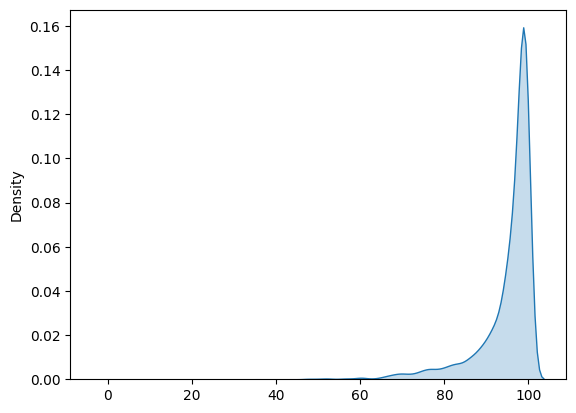

In [45]:
sns.kdeplot(accuracies, fill=True)

In [ ]:
model = MLP()
model.load_state_dict(torch.load(model_path))
model.eval()

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
X, y = get_moons_dataset()
with torch.no_grad():
    for angle in tqdm(angles):
        for i in tqdm(range(1000)):
            x = generate(model, angle, betas)
            x = torch.tensor(x, dtype=torch.float32)

            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_9824\438079878.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean accuracy: 94.47617499999998


<Axes: ylabel='Density'>

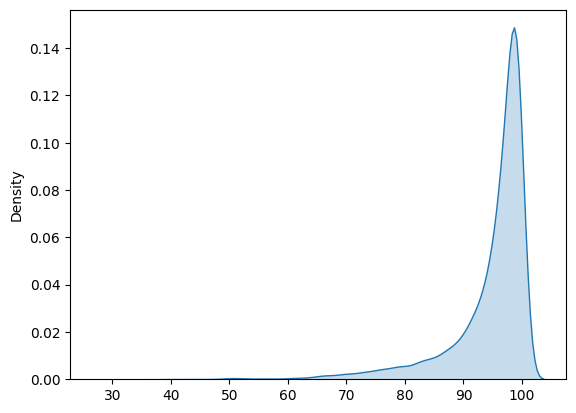

In [47]:
sns.kdeplot(accuracies, fill=True)

## Parameters distribution

In [49]:
model = MLP()
model.load_state_dict(torch.load(model_path))
model.eval()

angle = 0
accuracies = []
parameters = []
for i in tqdm(range(1000)):
    x = generate(model, angle, betas)
    parameters.append(x)
    x = torch.tensor(x, dtype=torch.float32)

    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

    accuracy = get_accuracy(x, X_rotated, y)
    accuracies.append(accuracy)

print("Mean accuracy:", np.mean(accuracies))
plt.plot(parameters.T)
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_9824\1001082699.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 95.9581


AttributeError: 'list' object has no attribute 'T'